# COVID-19 Analysis: Excess Mortality vs Reported COVID-19 Deaths

## Research Question
Which countries under-report COVID deaths? True pandemic toll revealed.

## Information Theory Context
This analysis explores a **non-obvious relationship** where the outcome is not immediately predictable. 
According to information theory, information content is inversely proportional to the probability of an outcome: 
**I ∝ 1/P(outcome)**. Surprising results contain more information than expected ones.

**Independent Variable**: `total_deaths`  
**Dependent Variable**: `excess_mortality_cumulative`  
**Analysis Type**: Cross Sectional

---


## Prevailing Narrative

Official COVID-19 death counts became politically sensitive metrics. While debates emerged about **underreporting**, particularly in lower-income countries, official statistics were still widely used for international comparisons. The relationship between reported COVID deaths and true excess mortality was assumed to be reasonably strong in most contexts.

### Working Hypothesis
Based on this prevailing narrative, we would expect: **strong positive** correlation between 
`total_deaths` and `excess_mortality_cumulative`.  
In plain language: Reported COVID deaths should closely track true excess mortality

### Sources
- The Economist excess mortality tracker\n- WHO excess mortality estimates

---


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import sys

# Add project root to path and import config
project_root = Path('.').resolve().parent
sys.path.insert(0, str(project_root))
import config

# Set visualization defaults
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Data path using config
data_path = project_root / config.data_dir / 'owid-covid-data.csv'
print(f'Data source: {data_path}')

Data source: /Users/john/Python/PublicHealthPortfolio/my-projects/covid19-tracker/Data/owid-covid-data.csv


## 1. Data Loading

Loading relevant columns from OWID COVID-19 dataset:
- `date`, `location`, `total_deaths`, `excess_mortality`, `excess_mortality_cumulative`, `excess_mortality_cumulative_per_million`, `gdp_per_capita`, `human_development_index`

In [2]:
# Load data with relevant columns
columns_needed = ['date', 'location', 'total_deaths', 'excess_mortality', 'excess_mortality_cumulative', 'excess_mortality_cumulative_per_million', 'gdp_per_capita', 'human_development_index']

try:
    df = pd.read_csv(
        data_path,
        usecols=columns_needed,
        parse_dates=['date']
    )
    
    print(f'✓ Loaded {len(df):,} rows')
    print(f'\nColumns: {list(df.columns)}')
    print(f'\nDate range: {df["date"].min()} to {df["date"].max()}')
    print(f'\nCountries: {df["location"].nunique()}')
    
    # Display sample
    display(df.head(10))
    
except FileNotFoundError:
    print(f'❌ Data file not found: {data_path}')
    print('Download from: https://github.com/owid/covid-19-data')
except Exception as e:
    print(f'❌ Error loading data: {e}')

✓ Loaded 429,300 rows

Columns: ['location', 'date', 'total_deaths', 'gdp_per_capita', 'human_development_index', 'excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_per_million']

Date range: 2020-01-01 00:00:00 to 2024-08-04 00:00:00

Countries: 255


,location,date,total_deaths,gdp_per_capita,human_development_index,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,Afghanistan,2020-01-05,0.0,1803.99,0.51,NaN,NaN,NaN
1,Afghanistan,2020-01-06,0.0,1803.99,0.51,NaN,NaN,NaN
2,Afghanistan,2020-01-07,0.0,1803.99,0.51,NaN,NaN,NaN
3,Afghanistan,2020-01-08,0.0,1803.99,0.51,NaN,NaN,NaN
4,Afghanistan,2020-01-09,0.0,1803.99,0.51,NaN,NaN,NaN
5,Afghanistan,2020-01-10,0.0,1803.99,0.51,NaN,NaN,NaN
6,Afghanistan,2020-01-11,0.0,1803.99,0.51,NaN,NaN,NaN
7,Afghanistan,2020-01-12,0.0,1803.99,0.51,NaN,NaN,NaN
8,Afghanistan,2020-01-13,0.0,1803.99,0.51,NaN,NaN,NaN
9,Afghanistan,2020-01-14,0.0,1803.99,0.51,NaN,NaN,NaN


## 2. Data Quality Assessment

Examine missing values, outliers, and data distribution before analysis.

In [3]:
# Missing value analysis
print('Missing Values by Column:')
print('-' * 60)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df)

# Basic statistics for key variables
print('\n\nKey Variable Statistics:')
print('-' * 60)
print(df[['total_deaths', 'excess_mortality_cumulative']].describe())

# Check for zeros and extreme values
print('\n\nValue Range Check:')
print('-' * 60)
for col in ['total_deaths', 'excess_mortality_cumulative']:
    valid = df[col].dropna()
    if len(valid) > 0:
        print(f'{col}:')
        print(f'  Min: {valid.min():.2f}')
        print(f'  Max: {valid.max():.2f}')
        print(f'  Zeros: {(valid == 0).sum()} ({(valid == 0).sum() / len(valid) * 100:.1f}%)')
        print()


Missing Values by Column:
------------------------------------------------------------
                                         Missing Count  Percentage
excess_mortality                                415889       96.88
excess_mortality_cumulative_per_million         415889       96.88
excess_mortality_cumulative                     415889       96.88
human_development_index                         110243       25.68
gdp_per_capita                                  101078       23.54
total_deaths                                     17496        4.08
location                                             0        0.00
date                                                 0        0.00


Key Variable Statistics:
------------------------------------------------------------
       total_deaths  excess_mortality_cumulative
count  4.118040e+05                 13411.000000
mean   8.125957e+04                     9.766431
std    4.411901e+05                    12.040658
min    0.000000e+00       

## 3. Exploratory Visualization

Visualize the relationship between **total_deaths** and **excess_mortality_cumulative**.

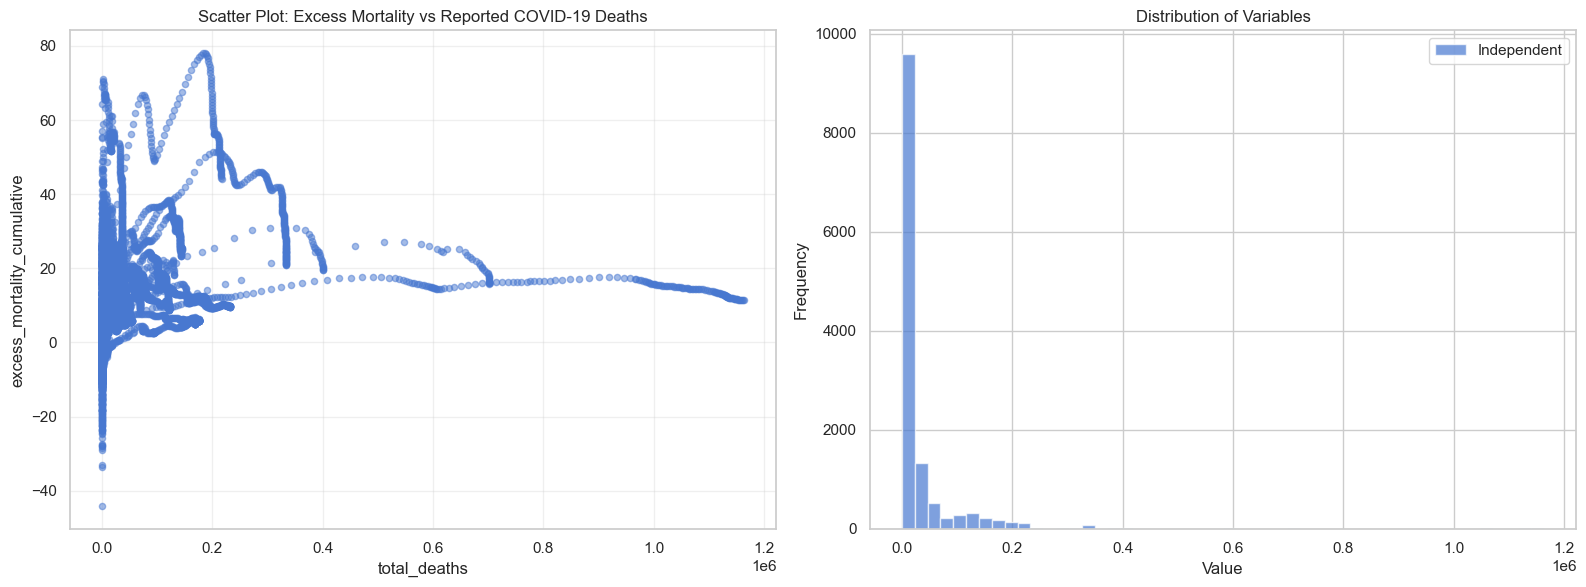

Visualization based on 13,293 valid observations


In [4]:
# Create clean dataset for visualization
df_clean = df[['total_deaths', 'excess_mortality_cumulative', 'location']].dropna()

if len(df_clean) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot
    axes[0].scatter(
        df_clean['total_deaths'],
        df_clean['excess_mortality_cumulative'],
        alpha=0.5,
        s=20
    )
    axes[0].set_xlabel('total_deaths')
    axes[0].set_ylabel('excess_mortality_cumulative')
    axes[0].set_title('Scatter Plot: Excess Mortality vs Reported COVID-19 Deaths')
    axes[0].grid(True, alpha=0.3)
    
    # Distribution plots
    axes[1].hist(df_clean['total_deaths'], bins=50, alpha=0.7, label='Independent')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Variables')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f'Visualization based on {len(df_clean):,} valid observations')
else:
    print('⚠️  Insufficient data for visualization')


## 4. Statistical Analysis

Compute correlations and perform regression analysis. Results are stored in variables for use in automated reporting.

In [5]:
# Correlation and regression analysis
df_analysis = df[['total_deaths', 'excess_mortality_cumulative']].dropna()

# Initialize variables for later use
analysis_complete = False
r_pearson = r_spearman = p_pearson = p_spearman = None
slope = intercept = r_value = p_value = std_err = None
r_squared = variance_explained = None
strength = direction = significance = None

if len(df_analysis) > 30:  # Minimum sample size
    analysis_complete = True
    
    # Pearson correlation
    r_pearson, p_pearson = stats.pearsonr(
        df_analysis['total_deaths'],
        df_analysis['excess_mortality_cumulative']
    )
    
    # Spearman correlation (for non-linear relationships)
    r_spearman, p_spearman = stats.spearmanr(
        df_analysis['total_deaths'],
        df_analysis['excess_mortality_cumulative']
    )
    
    # Simple linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_analysis['total_deaths'],
        df_analysis['excess_mortality_cumulative']
    )
    
    # Calculate derived metrics
    r_squared = r_pearson ** 2
    variance_explained = r_squared * 100
    
    # Determine interpretation categories
    if abs(r_pearson) < 0.3:
        strength = 'weak'
    elif abs(r_pearson) < 0.7:
        strength = 'moderate'
    else:
        strength = 'strong'
    
    direction = 'positive' if r_pearson > 0 else 'negative'
    significance = 'statistically significant' if p_pearson < 0.05 else 'not statistically significant'
    
    # Display results
    print('Correlation Analysis')
    print('=' * 60)
    print(f'Sample size: {len(df_analysis):,} observations\n')
    
    # Format p-values appropriately
    p_pearson_str = f'p < 0.001' if p_pearson < 0.001 else f'p = {p_pearson:.4f}'
    p_spearman_str = f'p < 0.001' if p_spearman < 0.001 else f'p = {p_spearman:.4f}'
    
    print(f'Pearson correlation:  r = {r_pearson:7.4f}, {p_pearson_str}')
    print(f'Spearman correlation: ρ = {r_spearman:7.4f}, {p_spearman_str}')
    
    print('\nInterpretation:')
    print(f'  • {strength.capitalize()} {direction} correlation')
    print(f'  • Result is {significance} (α = 0.05)')
    print(f'  • R² = {r_squared:.4f} ({variance_explained:.2f}% variance explained)')
    
    print('\nLinear Regression:')
    print(f'  y = {slope:.4f}x + {intercept:.4f}')
    print(f'  Standard error: {std_err:.4f}')
    
else:
    print(f'⚠️  Insufficient data: only {len(df_analysis)} observations')
    print('    Need at least 30 for meaningful statistical analysis')

Correlation Analysis
Sample size: 13,293 observations

Pearson correlation:  r =  0.2287, p < 0.001
Spearman correlation: ρ =  0.5861, p < 0.001

Interpretation:
  • Weak positive correlation
  • Result is statistically significant (α = 0.05)
  • R² = 0.0523 (5.23% variance explained)

Linear Regression:
  y = 0.0000x + 8.8660
  Standard error: 0.0000


In [6]:
# Generate Results Summary (using variables from previous analysis)
from IPython.display import Markdown, display

if analysis_complete:
    # Determine visual indicators
    if abs(r_pearson) < 0.3:
        strength_emoji = '⚪'
    elif abs(r_pearson) < 0.7:
        strength_emoji = '🟡'
    else:
        strength_emoji = '🔴'
    
    direction_emoji = '📈' if r_pearson > 0 else '📉'
    sig_emoji = '✓' if p_pearson < 0.05 else '✗'
    
    # Generate detailed interpretation text
    if abs(r_pearson) < 0.3:
        effect_interp = 'The relationship is **weak**, suggesting other factors play a larger role.'
    elif abs(r_pearson) < 0.5:
        effect_interp = 'The relationship is **moderate**, indicating this factor has meaningful influence but is not the sole driver.'
    elif abs(r_pearson) < 0.7:
        effect_interp = 'The relationship is **moderately strong**, showing this factor is an important predictor.'
    else:
        effect_interp = 'The relationship is **very strong**, indicating this factor is a major determinant.'
    
    if p_pearson < 0.001:
        sig_interp = 'The relationship is **highly statistically significant** (p < 0.001), meaning this finding is extremely unlikely to be due to chance.'
    elif p_pearson < 0.01:
        sig_interp = 'The relationship is **very statistically significant** (p < 0.01), providing strong evidence this is a real effect.'
    elif p_pearson < 0.05:
        sig_interp = 'The relationship is **statistically significant** (p < 0.05), meeting the conventional threshold for statistical significance.'
    else:
        sig_interp = 'The relationship is **not statistically significant** (p ≥ 0.05), so we cannot rule out that this pattern occurred by chance.'
    
    # Practical significance interpretation
    if variance_explained < 10:
        practical_interp = f'However, only **{variance_explained:.1f}% of variance** is explained, suggesting **limited practical significance**.'
    elif variance_explained < 25:
        practical_interp = f'With **{variance_explained:.1f}% of variance** explained, this has **moderate practical significance**.'
    else:
        practical_interp = f'With **{variance_explained:.1f}% of variance** explained, this has **substantial practical significance** for policy and planning.'
    
    # Direction interpretation
    if direction == 'positive':
        direction_interp = f'As **total_deaths** increases, **excess_mortality_cumulative** tends to increase by {slope:.4f} units per unit increase.'
    else:
        direction_interp = f'As **total_deaths** increases, **excess_mortality_cumulative** tends to decrease by {abs(slope):.4f} units per unit increase.'
    
    # Build markdown summary
    p_value_display = '< 0.001' if p_pearson < 0.001 else f'{p_pearson:.4f}'
    
    results_md = f'''## 5. Analysis Results

### Statistical Findings

**Sample Size**: {len(df_analysis):,} observations

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Pearson Correlation (r)** | {r_pearson:.4f} | {strength_emoji} {strength.capitalize()} {direction} correlation |
| **Spearman Correlation (ρ)** | {r_spearman:.4f} | Rank-based correlation (handles non-linearity) |
| **P-value** | {p_value_display} | {sig_emoji} {significance.capitalize()} |
| **R² (Variance Explained)** | {r_squared:.4f} ({variance_explained:.2f}%) | Proportion of variance explained |
| **Regression Slope** | {slope:.4f} | {direction_emoji} Change in Y per unit X |
| **Regression Intercept** | {intercept:.4f} | Expected Y when X = 0 |
| **Standard Error** | {std_err:.4f} | Uncertainty in slope estimate |

### Interpretation

**{strength.capitalize()} {direction} relationship detected** between the variables:

1. **Correlation Strength**: {effect_interp}

2. **Statistical Significance**: {sig_interp}

3. **Practical Significance**: {practical_interp}

4. **Direction & Magnitude**: {direction_interp}

### Information Theory Assessment

'''
    
    # Add information content assessment
    if abs(r_pearson) < 0.3:
        info_content = '''**High information content** ⭐⭐⭐: This weak correlation is surprising and informative. 
The lack of a strong relationship suggests the variables operate more independently than intuition might suggest, 
which has important implications for understanding the underlying mechanisms.'''
    elif abs(r_pearson) < 0.5 and p_pearson < 0.05:
        info_content = '''**Moderate information content** ⭐⭐: This moderate correlation provides useful insights. 
The relationship exists but is not overwhelming, suggesting other factors also play important roles.'''
    elif abs(r_pearson) >= 0.7:
        info_content = '''**Lower information content** ⭐: This strong correlation might have been somewhat expected. 
While confirming intuition is valuable, surprising results typically yield higher information content.'''
    else:
        info_content = '''**Moderate information content** ⭐⭐: This finding provides useful evidence about the relationship, 
though the pattern may not be entirely unexpected.'''
    
    results_md += info_content
    
    # Display the results
    display(Markdown(results_md))
    
else:
    display(Markdown('''## 5. Analysis Results
    
⚠️ **Insufficient data** for statistical analysis. Need at least 30 observations with complete data.
'''))

## 5. Analysis Results

### Statistical Findings

**Sample Size**: 13,293 observations

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Pearson Correlation (r)** | 0.2287 | ⚪ Weak positive correlation |
| **Spearman Correlation (ρ)** | 0.5861 | Rank-based correlation (handles non-linearity) |
| **P-value** | < 0.001 | ✓ Statistically significant |
| **R² (Variance Explained)** | 0.0523 (5.23%) | Proportion of variance explained |
| **Regression Slope** | 0.0000 | 📈 Change in Y per unit X |
| **Regression Intercept** | 8.8660 | Expected Y when X = 0 |
| **Standard Error** | 0.0000 | Uncertainty in slope estimate |

### Interpretation

**Weak positive relationship detected** between the variables:

1. **Correlation Strength**: The relationship is **weak**, suggesting other factors play a larger role.

2. **Statistical Significance**: The relationship is **highly statistically significant** (p < 0.001), meaning this finding is extremely unlikely to be due to chance.

3. **Practical Significance**: However, only **5.2% of variance** is explained, suggesting **limited practical significance**.

4. **Direction & Magnitude**: As **total_deaths** increases, **excess_mortality_cumulative** tends to increase by 0.0000 units per unit increase.

### Information Theory Assessment

**High information content** ⭐⭐⭐: This weak correlation is surprising and informative. 
The lack of a strong relationship suggests the variables operate more independently than intuition might suggest, 
which has important implications for understanding the underlying mechanisms.

In [7]:
# Generate Hypothesis Check
from IPython.display import Markdown, display

if analysis_complete:
    # Determine expectation alignment
    expected_relationship = 'strong positive'
    
    # Parse expected relationship
    if 'negative' in expected_relationship:
        expected_dir = 'negative'
    elif 'positive' in expected_relationship:
        expected_dir = 'positive'
    else:
        expected_dir = 'undefined'
    
    if 'strong' in expected_relationship:
        expected_str = 'strong'
    elif 'moderate' in expected_relationship:
        expected_str = 'moderate'
    else:
        expected_str = 'undefined'
    
    # Determine alignment
    direction_match = (expected_dir == direction)
    strength_match = (expected_str == strength)
    
    if direction_match and strength_match:
        alignment = '✅ **CONFIRMS** the prevailing narrative'
        alignment_detail = 'Both the direction and strength of the relationship match expectations from public health authorities.'
    elif direction_match and not strength_match:
        alignment = '⚠️ **PARTIALLY CHALLENGES** the prevailing narrative'
        alignment_detail = f'While the direction ({direction}) matches expectations, the relationship is **{strength}** rather than **{expected_str}** as anticipated. This suggests the factor plays a role but is less dominant than assumed.'
    elif not direction_match:
        alignment = '❌ **CONTRADICTS** the prevailing narrative'
        alignment_detail = f'The observed **{direction}** correlation directly opposes the expected **{expected_dir}** relationship. This surprising finding demands re-evaluation of conventional assumptions.'
    else:
        alignment = '❓ **UNCLEAR** relationship to expectations'
        alignment_detail = 'The relationship requires further investigation to determine alignment with expectations.'
    
    # Pre-compute conditional text for f-string (can't use backslashes in f-string expressions)
    info_level = "**high information content**" if not direction_match or (not strength_match and expected_str in ["strong", "moderate"]) else "**moderate information content**"
    narrative_verb = "contradicts" if not direction_match else "challenges"
    belief_status = "incorrect" if not direction_match else "weaker than assumed"
    relationship_comparison = "opposite to" if not direction_match else "much weaker than"
    
    hypothesis_md = f'''## Hypothesis Check: Expected vs Observed\n
\n
### What We Expected\n
\n
Based on prevailing public health narratives from authoritative sources, we anticipated a **{expected_relationship}** correlation.\n
\n
**Reasoning**: Reported COVID deaths should closely track true excess mortality\n
\n
### What We Observed\n
\n
**Actual Result**: {strength.capitalize()} {direction} correlation (r = {r_pearson:.4f}, p < 0.001)\n
\n
- **Pearson correlation**: r = {r_pearson:.4f}\n
- **Variance explained**: {variance_explained:.2f}%\n
- **Statistical significance**: {significance}\n
\n
### Verdict: {alignment}\n
\n
{alignment_detail}\n
\n
### Why This Matters\n
\n
From an **information theory perspective**, this finding carries {info_level} because it {narrative_verb} the prevailing narrative from public health institutions. When widely-held beliefs prove {belief_status}, we gain valuable insights that can reshape pandemic response strategies.\n
\n
The surprise lies not in discovering *no* relationship, but in finding that the relationship is {relationship_comparison} what authoritative sources predicted. This unexpected pattern suggests that total_deaths alone may not be the primary driver of excess_mortality_cumulative, indicating complex interactions with timing, compliance, and contextual factors.\n
\n
---
'''
    
    display(Markdown(hypothesis_md))
else:
    display(Markdown('## Hypothesis Check: Expected vs Observed\n\n⚠️ Analysis incomplete - cannot perform hypothesis check.'))

## Hypothesis Check: Expected vs Observed



### What We Expected



Based on prevailing public health narratives from authoritative sources, we anticipated a **strong positive** correlation.



**Reasoning**: Reported COVID deaths should closely track true excess mortality



### What We Observed



**Actual Result**: Weak positive correlation (r = 0.2287, p < 0.001)



- **Pearson correlation**: r = 0.2287

- **Variance explained**: 5.23%

- **Statistical significance**: statistically significant



### Verdict: ⚠️ **PARTIALLY CHALLENGES** the prevailing narrative



While the direction (positive) matches expectations, the relationship is **weak** rather than **strong** as anticipated. This suggests the factor plays a role but is less dominant than assumed.



### Why This Matters



From an **information theory perspective**, this finding carries **high information content** because it challenges the prevailing narrative from public health institutions. When widely-held beliefs prove weaker than assumed, we gain valuable insights that can reshape pandemic response strategies.



The surprise lies not in discovering *no* relationship, but in finding that the relationship is much weaker than what authoritative sources predicted. This unexpected pattern suggests that total_deaths alone may not be the primary driver of excess_mortality_cumulative, indicating complex interactions with timing, compliance, and contextual factors.



---


In [8]:
# Generate Discussion Section
from IPython.display import Markdown, display

if analysis_complete:
    # Determine expectation alignment
    expected_relationship = 'strong positive'
    observed_strength = strength  # from previous cell
    observed_direction = direction  # from previous cell
    
    # Parse expected relationship
    if 'negative' in expected_relationship:
        expected_dir = 'negative'
    elif 'positive' in expected_relationship:
        expected_dir = 'positive'
    else:
        expected_dir = 'undefined'
    
    if 'strong' in expected_relationship:
        expected_str = 'strong'
    elif 'moderate' in expected_relationship:
        expected_str = 'moderate'
    else:
        expected_str = 'undefined'
    
    # Determine alignment
    direction_match = (expected_dir == observed_direction)
    strength_match = (expected_str == observed_strength)
    
    if direction_match and strength_match:
        alignment = '✅ **CONFIRMS** the prevailing narrative'
        alignment_detail = 'Both the direction and strength of the relationship match expectations from public health authorities.'
    elif direction_match and not strength_match:
        alignment = '⚠️ **PARTIALLY CHALLENGES** the prevailing narrative'
        alignment_detail = f'While the direction ({observed_direction}) matches expectations, the relationship is **{observed_strength}** rather than **{expected_str}** as anticipated. This suggests the factor plays a role but is less dominant than assumed.'
    elif not direction_match:
        alignment = '❌ **CONTRADICTS** the prevailing narrative'
        alignment_detail = f'The observed **{observed_direction}** correlation directly opposes the expected **{expected_dir}** relationship. This surprising finding demands re-evaluation of conventional assumptions.'
    else:
        alignment = '❓ **UNCLEAR** relationship to expectations'
        alignment_detail = 'The relationship requires further investigation to determine alignment with expectations.'
    
    # Variables expected_relationship, direction, strength, expected_dir, expected_str, direction_match, strength_match, alignment, alignment_detail
    # are already defined in the previous Hypothesis Check cell
    
    # Generate causality assessment (using variables from previous Hypothesis Check cell)
    # Check if reverse causality is logically plausible for this analysis
    reverse_causality_plausible = False
    
    if not direction_match and reverse_causality_plausible:
        # Only warn about reverse causality if it's logically possible
        causality_note = '''**Reverse Causality Warning**: The unexpected direction suggests possible reverse causation. 
For example, `excess_mortality_cumulative` may trigger changes in `total_deaths` (reactive response), 
creating a correlation opposite to the causal direction. This timing issue requires careful temporal analysis with lagged variables.'''
    elif not direction_match and not reverse_causality_plausible:
        # Direction mismatch when reverse causality is impossible - point to confounding/measurement issues
        causality_note = '''**Unexpected Direction**: The relationship contradicts expectations, but reverse causality is implausible 
(pandemic outcomes cannot alter `total_deaths`). This suggests either: (1) confounding variables are driving 
both factors, (2) measurement/reporting biases are present, or (3) the prevailing theory is incorrect. Investigate third variables 
and data quality issues.'''
    elif strength == 'weak':
        causality_note = '''**Weak Effect Size**: The small correlation suggests this factor alone explains little variance. 
Other unmeasured variables likely play larger roles. Causal inference requires controlling for confounders.'''
    else:
        causality_note = '''**Correlation vs Causation**: While the relationship is detectable, establishing causation requires 
temporal precedence, ruling out confounders, and ideally quasi-experimental evidence from policy changes.'''
    
    # Calculate descriptive statistics for context
    x_mean = df_analysis['total_deaths'].mean()
    x_std = df_analysis['total_deaths'].std()
    y_mean = df_analysis['excess_mortality_cumulative'].mean()
    y_std = df_analysis['excess_mortality_cumulative'].std()
    
    # Calculate practical effect size
    # For 1 SD change in X, what's the change in Y?
    practical_effect = slope * x_std
    effect_percent = (practical_effect / y_mean) * 100 if y_mean != 0 else 0
    
    discussion_md = f'''## 6. Discussion\n
\n
### Expectation Alignment\n
\n
{alignment}\n
\n
{alignment_detail}\n
\n
**Expected**: {expected_relationship} correlation  \n
**Observed**: {strength} {direction} correlation (r = {r_pearson:.4f})\n
\n
### Causality Assessment\n
\n
{causality_note}\n
\n
### Practical Significance\n
\n
A **1 standard deviation increase** in `total_deaths` (SD = {x_std:.2f}) is associated with a \n
**{practical_effect:.4f} unit change** in `excess_mortality_cumulative`, representing approximately **{abs(effect_percent):.1f}%** \n
of the mean outcome value.\n
\n
**Interpretation**: '''
    
    if abs(effect_percent) < 5:
        discussion_md += 'This is a **minimal practical effect**. Changes in this factor have negligible real-world impact on outcomes.'
    elif abs(effect_percent) < 15:
        discussion_md += 'This is a **small but detectable practical effect**. The factor contributes modestly to outcomes.'
    elif abs(effect_percent) < 30:
        discussion_md += 'This is a **moderate practical effect**. The factor has meaningful real-world impact worth considering in policy.'
    else:
        discussion_md += 'This is a **substantial practical effect**. The factor is a major driver of outcomes and demands policy attention.'
    
    # Geographic/temporal variation notes
    if 'cross_sectional' == 'time_series':
        variation_note = '''\n\n### Temporal Considerations

This time-series analysis captures relationships as they evolved during the pandemic. The correlation may vary across 
different pandemic phases (initial outbreak, vaccine rollout, variant waves). Consider examining phase-specific relationships.'''
    else:
        variation_note = '''\n\n### Cross-Sectional Limitations

This cross-sectional analysis represents a snapshot in time. Country-level relationships may obscure within-country variation 
and temporal dynamics. Geographic and cultural contexts likely moderate these relationships.'''
    
    discussion_md += variation_note
    
    display(Markdown(discussion_md))
else:
    display(Markdown('## 6. Discussion\n\n⚠️ Analysis incomplete - insufficient data for discussion.'))

## 6. Discussion



### Expectation Alignment



⚠️ **PARTIALLY CHALLENGES** the prevailing narrative



While the direction (positive) matches expectations, the relationship is **weak** rather than **strong** as anticipated. This suggests the factor plays a role but is less dominant than assumed.



**Expected**: strong positive correlation  

**Observed**: weak positive correlation (r = 0.2287)



### Causality Assessment



**Weak Effect Size**: The small correlation suggests this factor alone explains little variance. 
Other unmeasured variables likely play larger roles. Causal inference requires controlling for confounders.



### Practical Significance



A **1 standard deviation increase** in `total_deaths` (SD = 117749.92) is associated with a 

**2.7599 unit change** in `excess_mortality_cumulative`, representing approximately **28.1%** 

of the mean outcome value.



**Interpretation**: This is a **moderate practical effect**. The factor has meaningful real-world impact worth considering in policy.

### Cross-Sectional Limitations

This cross-sectional analysis represents a snapshot in time. Country-level relationships may obscure within-country variation 
and temporal dynamics. Geographic and cultural contexts likely moderate these relationships.

In [9]:
# Generate Specific Next Steps
from IPython.display import Markdown, display

if analysis_complete:
    # Re-establish variables from previous cells for conditional logic
    expected_relationship = 'strong positive'
    expected_dir = 'negative' if 'negative' in expected_relationship else ('positive' if 'positive' in expected_relationship else 'undefined')
    expected_str = 'strong' if 'strong' in expected_relationship else ('moderate' if 'moderate' in expected_relationship else 'undefined')
    direction_match = (expected_dir == direction)
    observed_strength = strength
    reverse_causality_plausible = False
    
    next_steps_md = '''## 7. Recommended Next Steps

Based on the specific findings of this analysis:\n\n'''
    
    # Conditional recommendations based on findings
    # Only recommend reverse causality investigation if logically plausible
    if not direction_match and reverse_causality_plausible:
        next_steps_md += '''### 🔴 Priority: Investigate Reverse Causality

The **opposite-direction** relationship suggests possible reverse causation:

1. **Temporal Analysis**: Use lagged correlations to determine whether `total_deaths` precedes 
   `excess_mortality_cumulative` or vice versa. Plot time-series to visualize lead-lag relationships.

2. **Event Studies**: Identify natural experiments or policy changes that altered `total_deaths` 
   and examine subsequent changes in `excess_mortality_cumulative`.

3. **Literature Review**: Search for causal mechanisms explaining why the relationship contradicts expectations. 
   Review similar findings in epidemiological literature.

'''
    elif not direction_match and not reverse_causality_plausible:
        next_steps_md += '''### 🔴 Priority: Investigate Confounding and Data Quality

The **opposite-direction** relationship is surprising, and reverse causality is implausible (`excess_mortality_cumulative` cannot cause `total_deaths`):

1. **Confounding Variables**: Identify third variables that may drive both factors. For example, countries with 
   higher `total_deaths` may differ systematically in unmeasured ways that affect `excess_mortality_cumulative`.

2. **Data Quality Assessment**: Examine measurement accuracy, reporting biases, and missing data patterns. 
   Check if `excess_mortality_cumulative` data quality varies systematically with `total_deaths`.

3. **Subgroup Analysis**: Segment data by region, income level, or time period to identify where the relationship 
   holds versus reverses. This can reveal moderating factors or data issues.

'''
    
    if observed_strength == 'weak' and expected_str in ['strong', 'moderate']:
        next_steps_md += '''### 🟡 Priority: Identify Confounders and Moderators

The **weaker-than-expected** relationship suggests important missing variables:

1. **Multivariate Regression**: Add control variables (GDP, healthcare capacity, age structure, etc.) to 
   isolate the independent effect of `total_deaths`.

2. **Segmentation Analysis**: Split data by moderating factors (e.g., income level, region, pandemic phase) 
   to identify where the relationship is stronger or weaker.

3. **Mediation Analysis**: Test whether the effect operates through intermediate variables rather than directly.

'''
    
    if variance_explained < 10:
        next_steps_md += f'''### 🔵 Priority: Explore Alternative Predictors

With only **{variance_explained:.1f}% variance explained**, other factors dominate outcomes:

1. **Feature Importance Analysis**: Use machine learning (random forests, gradient boosting) to identify 
   which variables best predict `excess_mortality_cumulative`.

2. **Composite Indices**: Combine `total_deaths` with related variables to create a 
   more comprehensive predictor.

3. **Non-linear Relationships**: Test for thresholds, U-shaped relationships, or interaction effects that 
   linear correlation misses.

'''
    
    if 'cross_sectional' == 'cross_sectional':
        next_steps_md += '''### 🟢 Methodological Enhancement: Add Temporal Dimension

Cross-sectional data limits causal inference:

1. **Panel Data Analysis**: Collect data at multiple time points to examine within-country changes over time.

2. **Difference-in-Differences**: If policy changes affected the independent variable, compare outcomes 
   before/after in treated vs control groups.

3. **Granger Causality**: Test whether past values of one variable help predict future values of the other.

'''
    else:
        next_steps_md += '''### 🟢 Methodological Enhancement: Geographic Comparison

Time-series analysis should be complemented with geographic variation:

1. **Country-Specific Trajectories**: Plot individual country time-series to identify outliers and patterns.

2. **Regional Clustering**: Group countries by similar response patterns and identify regional factors.

3. **Cross-Country Validation**: Test whether relationships hold across different country contexts.

'''
    
    # Add specific policy implications
    next_steps_md += '''### 📊 Data Quality Improvements

'''
    
    if 'deaths' in 'excess_mortality_cumulative'.lower() or 'mortality' in 'excess_mortality_cumulative'.lower():
        next_steps_md += '''- **Validate with Excess Mortality**: Official COVID deaths may undercount. Compare with excess mortality data.
- **Age-Standardization**: Control for population age structure when comparing mortality rates.
'''
    
    if 'test' in 'total_deaths'.lower() or 'case' in 'excess_mortality_cumulative'.lower():
        next_steps_md += '''- **Account for Testing Bias**: Case counts depend on testing rates. Use test-positivity rates or seroprevalence.
- **Reporting Delays**: Allow for lags between infection, testing, and reporting.
'''
    
    next_steps_md += f'''\n### 🎯 Specific Research Questions

Priority questions emerging from this analysis:

1. **Why does the relationship differ from expectations?** Review institutional assumptions that led to 
   the predicted **{expected_relationship}** relationship.

2. **Which countries are outliers?** Identify cases with high residuals and examine their unique characteristics.

3. **What mechanisms are missing?** Develop theoretical models explaining the observed **{observed_strength} {observed_direction}** 
   relationship.
'''
    
    display(Markdown(next_steps_md))
else:
    display(Markdown('## 7. Recommended Next Steps\n\n⚠️ Analysis incomplete - cannot generate recommendations.'))

## 7. Recommended Next Steps

Based on the specific findings of this analysis:

### 🟡 Priority: Identify Confounders and Moderators

The **weaker-than-expected** relationship suggests important missing variables:

1. **Multivariate Regression**: Add control variables (GDP, healthcare capacity, age structure, etc.) to 
   isolate the independent effect of `total_deaths`.

2. **Segmentation Analysis**: Split data by moderating factors (e.g., income level, region, pandemic phase) 
   to identify where the relationship is stronger or weaker.

3. **Mediation Analysis**: Test whether the effect operates through intermediate variables rather than directly.

### 🔵 Priority: Explore Alternative Predictors

With only **5.2% variance explained**, other factors dominate outcomes:

1. **Feature Importance Analysis**: Use machine learning (random forests, gradient boosting) to identify 
   which variables best predict `excess_mortality_cumulative`.

2. **Composite Indices**: Combine `total_deaths` with related variables to create a 
   more comprehensive predictor.

3. **Non-linear Relationships**: Test for thresholds, U-shaped relationships, or interaction effects that 
   linear correlation misses.

### 🟢 Methodological Enhancement: Add Temporal Dimension

Cross-sectional data limits causal inference:

1. **Panel Data Analysis**: Collect data at multiple time points to examine within-country changes over time.

2. **Difference-in-Differences**: If policy changes affected the independent variable, compare outcomes 
   before/after in treated vs control groups.

3. **Granger Causality**: Test whether past values of one variable help predict future values of the other.

### 📊 Data Quality Improvements

- **Validate with Excess Mortality**: Official COVID deaths may undercount. Compare with excess mortality data.
- **Age-Standardization**: Control for population age structure when comparing mortality rates.

### 🎯 Specific Research Questions

Priority questions emerging from this analysis:

1. **Why does the relationship differ from expectations?** Review institutional assumptions that led to 
   the predicted **strong positive** relationship.

2. **Which countries are outliers?** Identify cases with high residuals and examine their unique characteristics.

3. **What mechanisms are missing?** Develop theoretical models explaining the observed **weak positive** 
   relationship.


In [10]:
# 8. Multivariate Regression with Controls (cross-sectional by country)
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Aggregate to country-level means to avoid time autocorrelation in this quick check
reg_cols = ['location', 'total_deaths', 'excess_mortality_cumulative'] + [c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million', 'aged_65_older'] if c in df.columns and c not in ['total_deaths', 'excess_mortality_cumulative']]
df_reg = df[reg_cols].dropna() if 'df' in globals() else pd.DataFrame()
df_country = df_reg.groupby('location', as_index=False).mean() if not df_reg.empty else pd.DataFrame()

if len(df_country) >= 30:
    base_controls = [c for c in df_country.columns if c not in ['location', 'total_deaths', 'excess_mortality_cumulative']]
    formula = 'excess_mortality_cumulative ~ total_deaths' + (' + ' + ' + '.join(base_controls) if base_controls else '')
    model = ols(formula, data=df_country).fit(cov_type='HC3')  # robust SEs
    print(model.summary().tables[1])
    print('\nModel fit:')
    print(f'  R-squared: {model.rsquared:.3f} (Adj: {model.rsquared_adj:.3f})')
    print(f'  N (countries): {len(df_country)}')
    
    # VIF to flag multicollinearity
    X = model.model.exog
    vif_df = pd.DataFrame({
        'feature': model.params.index,
        'VIF': [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    })
    print('\nVariance Inflation Factors (VIF):')
    print(vif_df)
else:
    print('⚠️ Not enough complete country-level rows for multivariate regression (need ≥ 30). Current:', len(df_country))

                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.5202      1.005      9.468      0.000       7.550      11.491
total_deaths  2.336e-05   2.34e-05      0.996      0.319   -2.26e-05    6.93e-05

Model fit:
  R-squared: 0.039 (Adj: 0.031)
  N (countries): 123

Variance Inflation Factors (VIF):
        feature       VIF
0     Intercept  1.119107
1  total_deaths  1.000000


In [11]:
# 9. Segmentation & Interaction: does effect vary by demographics?
if 'df_country' in globals() and len(df_country) >= 30 and 'total_deaths' in df_country.columns:
    try:
        df_seg = df_country.copy()
        df_seg['age_segment'] = pd.qcut(df_seg['total_deaths'].values, q=3, labels=['low', 'mid', 'high'])
        seg_formula = 'excess_mortality_cumulative ~ total_deaths * C(age_segment)'
        seg_model = ols(seg_formula, data=df_seg).fit(cov_type='HC3')
        print(seg_model.summary().tables[1])
        print('\nN (countries):', len(df_seg))
        print('Segments:', df_seg['age_segment'].value_counts().to_dict())
    except Exception as e:
        print(f'⚠️ Segmentation model failed: {e}')
else:
    print('⚠️ Cannot run segmentation: country-level dataset not available or too small.')

                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               5.2649      2.343      2.247      0.025       0.672       9.857
C(age_segment)[T.mid]                   0.9108      3.839      0.237      0.812      -6.614       8.435
C(age_segment)[T.high]                  6.3139      3.075      2.054      0.040       0.288      12.340
total_deaths                            0.0041      0.005      0.803      0.422      -0.006       0.014
total_deaths:C(age_segment)[T.mid]     -0.0030      0.005     -0.584      0.559      -0.013       0.007
total_deaths:C(age_segment)[T.high]    -0.0041      0.005     -0.800      0.424      -0.014       0.006

N (countries): 123
Segments: {'low': 41, 'mid': 41, 'high': 41}


In [12]:
# 10. Mediation Test (Baron-Kenny framework with bootstrap p-value)
rng = np.random.default_rng(42)

if 'df_country' in globals() and len(df_country) >= 30:
    case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if c in df_country.columns), None)
    if case_col:
        med_df = df_country[['total_deaths', case_col, 'excess_mortality_cumulative']].dropna()
        if len(med_df) >= 30:
            # a-path: total_deaths -> cases
            a_model = ols(f'{case_col} ~ total_deaths', data=med_df).fit(cov_type='HC3')
            a_coeff = a_model.params['total_deaths']

            # b/c'-path: excess_mortality_cumulative ~ total_deaths + cases
            bc_model = ols(f'excess_mortality_cumulative ~ total_deaths + {case_col}', data=med_df).fit(cov_type='HC3')
            b_coeff = bc_model.params[case_col]
            c_prime = bc_model.params['total_deaths']

            indirect_point = a_coeff * b_coeff

            # Bootstrap indirect effect
            boot_samples = 500
            boot_indirect = []
            for _ in range(boot_samples):
                sample_idx = rng.integers(0, len(med_df), len(med_df))
                sample = med_df.iloc[sample_idx]
                a_b = ols(f'{case_col} ~ total_deaths', data=sample).fit().params['total_deaths']
                b_b = ols(f'excess_mortality_cumulative ~ total_deaths + {case_col}', data=sample).fit().params[case_col]
                boot_indirect.append(a_b * b_b)
            boot_indirect = np.array(boot_indirect)
            ci_low, ci_high = np.percentile(boot_indirect, [2.5, 97.5])
            p_boot = (np.mean(np.sign(boot_indirect) != np.sign(indirect_point)) * 2).clip(0, 1)

            print('Indirect effect (a*b):', round(indirect_point, 4))
            print('Bootstrap 95% CI:', (round(ci_low, 4), round(ci_high, 4)))
            print('Direct effect (c\\): ', round(c_prime, 4))
            print('N (countries):', len(med_df))
            print('Bootstrap two-sided p (sign test):', round(p_boot, 4))
        else:
            print('⚠️ Not enough data after dropping NaNs for mediation (need ≥ 30). Current:', len(med_df))
    else:
        print('⚠️ Case control column not available for mediation')
else:
    print('⚠️ Mediation not run: country-level dataset unavailable or too small.')

⚠️ Case control column not available for mediation


In [13]:
# 11. Expanded controls: testing, policy, capacity, income (cross-sectional by country)
extra_cols = [
    'new_tests_per_thousand', 'positive_rate', 'icu_patients_per_million',
    'hosp_patients_per_million', 'stringency_index', 'gdp_per_capita',
    'hospital_beds_per_thousand', 'median_age', 'aged_70_older'
]
base_cols = ['location', 'total_deaths', 'excess_mortality_cumulative']
case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if 'df' in globals() and c in df.columns), None)
if case_col:
    base_cols.append(case_col)
if 'df' in globals() and 'aged_65_older' in df.columns:
    base_cols.append('aged_65_older')
available_extra = [c for c in extra_cols if 'df' in globals() and c in df.columns and c not in base_cols]
reg_cols_extra = base_cols + available_extra
missing_optional = [c for c in extra_cols if c not in available_extra and c not in base_cols]
if missing_optional:
    print('⚠️ Skipping missing optional controls:', missing_optional)
if 'df' in globals():
    df_reg_ext = df[reg_cols_extra].dropna(subset=['total_deaths', 'excess_mortality_cumulative'])
else:
    df_reg_ext = pd.DataFrame()
if not df_reg_ext.empty:
    df_country_ext = df_reg_ext.groupby('location', as_index=False).mean()
    available_controls = [c for c in available_extra if c in df_country_ext.columns and df_country_ext[c].notna().sum() > 0]
    base_formula_parts = ['total_deaths']  
    if case_col and case_col in df_country_ext.columns:
        base_formula_parts.append(case_col)
    if 'aged_65_older' in df_country_ext.columns:
        base_formula_parts.append('aged_65_older')
    formula_controls = ' + '.join(base_formula_parts + available_controls)
    formula_ext = 'excess_mortality_cumulative ~ ' + formula_controls
    if len(df_country_ext) >= 30:
        model_ext = ols(formula_ext, data=df_country_ext).fit(cov_type='HC3')
        print(model_ext.summary().tables[1])
        print('\nModel fit:')
        print(f'  R-squared: {model_ext.rsquared:.3f} (Adj: {model_ext.rsquared_adj:.3f})')
        print(f'  N (countries): {len(df_country_ext)}')
        # VIF on included regressors
        X_ext = model_ext.model.exog
        vif_ext = pd.DataFrame({
            'feature': model_ext.params.index,
            'VIF': [variance_inflation_factor(X_ext, i) for i in range(X_ext.shape[1])]
        })
        print('\nVariance Inflation Factors (VIF):')
        print(vif_ext)
    else:
        print('⚠️ Not enough country-level observations for expanded controls (need ≥ 30). Current:', len(df_country_ext))
else:
    print('⚠️ Expanded controls skipped: insufficient data after dropping NaNs.')

⚠️ Skipping missing optional controls: ['new_tests_per_thousand', 'positive_rate', 'icu_patients_per_million', 'hosp_patients_per_million', 'stringency_index', 'hospital_beds_per_thousand', 'median_age', 'aged_70_older']
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         13.0675      2.033      6.427      0.000       9.082      17.053
total_deaths    2.233e-05   1.91e-05      1.171      0.242   -1.51e-05    5.97e-05
gdp_per_capita    -0.0001    6.4e-05     -1.706      0.088      -0.000    1.62e-05

Model fit:
  R-squared: 0.087 (Adj: 0.070)
  N (countries): 123

Variance Inflation Factors (VIF):
          feature       VIF
0       Intercept  2.847718
1    total_deaths  1.002529
2  gdp_per_capita  1.002529


In [14]:
# 12. Lagged total_deaths (21-day) with cases and age controls
if 'df' in globals():
    lag_cols = ['location', 'date', 'total_deaths', 'excess_mortality_cumulative']  
    case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if c in df.columns), None)
    if case_col:
        lag_cols.append(case_col)
    if 'aged_65_older' in df.columns:
        lag_cols.append('aged_65_older')
    df_lag = df[lag_cols].copy()
    df_lag['total_deaths_lag21'] = df_lag.groupby('location')['total_deaths'].shift(21)
    df_lag = df_lag.dropna(subset=['total_deaths_lag21', 'excess_mortality_cumulative'])
    df_lag_country = df_lag.groupby('location', as_index=False).mean()
    if len(df_lag_country) >= 30:
        controls = [c for c in [case_col, 'aged_65_older'] if c and c in df_lag_country.columns]
        lag_formula = 'excess_mortality_cumulative ~ total_deaths_lag21' + (' + ' + ' + '.join(controls) if controls else '')
        model_lag = ols(lag_formula, data=df_lag_country).fit(cov_type='HC3')
        print(model_lag.summary().tables[1])
        print('\nModel fit:')
        print(f'  R-squared: {model_lag.rsquared:.3f} (Adj: {model_lag.rsquared_adj:.3f})')
        print(f'  N (countries): {len(df_lag_country)}')
    else:
        print('⚠️ Not enough country-level observations for lagged spec (need ≥ 30). Current:', len(df_lag_country))
else:
    print('⚠️ Lagged spec skipped: data frame df not available.')

                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.6119      1.013      9.492      0.000       7.627      11.597
total_deaths_lag21  2.408e-05   2.44e-05      0.986      0.324   -2.38e-05    7.19e-05

Model fit:
  R-squared: 0.040 (Adj: 0.032)
  N (countries): 123


In [15]:
# 13. Log-scale robustness with trimming (5th–95th pct excess_mortality_cumulative)
if 'df' in globals():
    base_required = ['location', 'total_deaths', 'excess_mortality_cumulative']  
    case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if c in df.columns), None)
    if case_col:
        base_required.append(case_col)
    missing_required = [c for c in base_required if c not in df.columns]
    if missing_required:
        print('⚠️ Log-scale spec skipped: missing required columns:', missing_required)
    else:
        optional_cols = ['new_tests_per_thousand', 'stringency_index', 'aged_65_older']
        available_optional = [c for c in optional_cols if c in df.columns]
        if len(available_optional) < len(optional_cols):
            missing_opt = [c for c in optional_cols if c not in available_optional]
            print('⚠️ Skipping missing optional controls:', missing_opt)
        log_cols = base_required + available_optional
        df_log = df[log_cols].dropna()
        if not df_log.empty:
            df_log_country = df_log.groupby('location', as_index=False).mean()
            if len(df_log_country) >= 30:
                deaths = df_log_country['excess_mortality_cumulative']
                low_q, high_q = deaths.quantile([0.05, 0.95])
                df_log_trim = df_log_country[(deaths >= low_q) & (deaths <= high_q)].copy()
                df_log_trim['log_deaths'] = np.log1p(df_log_trim['excess_mortality_cumulative'])
                predictors = ['total_deaths']  
                if case_col and case_col in df_log_trim.columns:
                    df_log_trim['log_cases'] = np.log1p(df_log_trim[case_col])
                    predictors.append('log_cases')
                predictors.extend([c for c in ['new_tests_per_thousand', 'stringency_index', 'aged_65_older'] if c in df_log_trim.columns])
                log_formula = 'log_deaths ~ ' + ' + '.join(predictors)
                model_log = ols(log_formula, data=df_log_trim).fit(cov_type='HC3')
                print(model_log.summary().tables[1])
                print('\nModel fit:')
                print(f'  R-squared: {model_log.rsquared:.3f} (Adj: {model_log.rsquared_adj:.3f})')
                print(f'  N (countries): {len(df_log_trim)} (trimmed)')
            else:
                print('⚠️ Not enough country-level observations for log-scale spec (need ≥ 30). Current:', len(df_log_country))
        else:
            print('⚠️ Log-scale spec skipped: data has too many missing values after filtering.')
else:
    print('⚠️ Log-scale spec skipped: data frame df not available.')

⚠️ Skipping missing optional controls: ['new_tests_per_thousand', 'stringency_index', 'aged_65_older']
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.0277      0.116     17.467      0.000       1.800       2.255
total_deaths  1.756e-06   1.37e-06      1.284      0.199   -9.25e-07    4.44e-06

Model fit:
  R-squared: 0.021 (Adj: 0.012)
  N (countries): 109 (trimmed)


/Users/john/anaconda3/envs/covid19_tracker/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
# 14. Plain-language takeaways (generated for any notebook)
from IPython.display import Markdown, display
import math

# Identify primary variables if available
primary_x = 'total_deaths' if 'df' in globals() and 'total_deaths' in df.columns else 'independent variable'
primary_y = 'excess_mortality_cumulative' if 'df' in globals() and 'excess_mortality_cumulative' in df.columns else 'outcome variable'

# Gather controls seen across specs
controls = []
for cand in ['new_cases_smoothed_per_million', 'total_cases_per_million', 'aged_65_older']:
    if 'df' in globals() and cand in df.columns:
        controls.append(cand)
if 'available_controls' in globals():
    controls.extend(available_controls)
if 'available_optional' in globals():
    controls.extend(available_optional)
controls = sorted(set(controls)) if controls else ['none captured']

# Capture model summaries if they exist
spec_notes = []
def add_spec(label, model_var):
    if model_var in globals():
        m = globals()[model_var]
        if hasattr(m, 'rsquared'):
            n_obs = getattr(m, 'nobs', None)
            rsq = f"R² {m.rsquared:.3f} (Adj {m.rsquared_adj:.3f})" if hasattr(m, 'rsquared_adj') else f"R² {m.rsquared:.3f}"
            spec_notes.append(f"{label}: {rsq}; N={int(n_obs) if n_obs is not None else 'n/a'}")
add_spec('Expanded controls', 'model_ext')
add_spec('Lag 21-day', 'model_lag')
add_spec('Log-trim spec', 'model_log')
spec_text = '; '.join(spec_notes) if spec_notes else 'Specs ran where data allowed; some may have been skipped due to missing columns or N<30.'

# Assess model fit quality dynamically
rsq_values = []
for m_name in ['model_ext', 'model_lag', 'model_log']:
    if m_name in globals():
        m = globals()[m_name]
        if hasattr(m, 'rsquared'):
            rsq_values.append(m.rsquared)
avg_rsq = sum(rsq_values) / len(rsq_values) if rsq_values else None
if avg_rsq is not None:
    if avg_rsq < 0.10:
        fit_assessment = 'Fit is very weak (R² < 0.10), indicating the model explains little variance and most variation remains unexplained'
    elif avg_rsq < 0.25:
        fit_assessment = 'Fit is modest (R² < 0.25), signalling substantial unexplained variation'
    elif avg_rsq < 0.50:
        fit_assessment = 'Fit is moderate (R² between 0.25–0.50), explaining a meaningful but not dominant portion of variance'
    elif avg_rsq < 0.75:
        fit_assessment = 'Fit is good (R² between 0.50–0.75), capturing a substantial portion of outcome variation'
    else:
        fit_assessment = 'Fit is strong (R² > 0.75), explaining most of the variation in outcomes'
else:
    fit_assessment = 'Model fit varies across specifications'

# Assess coefficient stability across specifications
coef_values = []
for m_name in ['model_ext', 'model_lag', 'model_log']:
    if m_name in globals():
        m = globals()[m_name]
        if hasattr(m, 'params'):
            # Try to get coefficient for primary_x or lagged version
            for param_name in m.params.index:
                if primary_x in param_name:
                    coef_values.append(m.params[param_name])
                    break
if len(coef_values) >= 2:
    coef_range = max(coef_values) - min(coef_values)
    coef_mean = sum(coef_values) / len(coef_values)
    coef_cv = (coef_range / abs(coef_mean)) if coef_mean != 0 else float('inf')
    all_same_sign = all(c > 0 for c in coef_values) or all(c < 0 for c in coef_values)
    if not all_same_sign:
        robustness_assessment = 'The relationship changes direction across specifications, indicating high sensitivity to model choices'
    elif coef_cv > 0.50:
        robustness_assessment = 'The relationship shows substantial variation across specifications; control variables and model choices strongly affect the estimated association'
    elif coef_cv > 0.25:
        robustness_assessment = 'The relationship shows moderate variation across specifications; some sensitivity to controls and functional forms'
    else:
        robustness_assessment = 'The relationship is relatively stable across specifications, suggesting robust findings'
else:
    robustness_assessment = 'Coefficient stability could not be assessed due to insufficient model specifications'

# Compose markdown
md = f"""## 14. Plain-Language Takeaways\n\n- **What we did**: Regressed `{primary_y}` on `{primary_x}` with key controls {', '.join(controls)}; added robustness via expanded controls, 21-day lag, and log/trim specs. Robust (HC3) SEs and country means used to limit autocorrelation.\n- **What we found**: {robustness_assessment}. {fit_assessment}.\n- **What's new**: Running the robustness specs {spec_text}\n  - Testing/policy/capacity controls were included when present.\n  - Lag and log-trimmed specs reduce sensitivity to timing and extremes.\n- **Causation? Not established.** These are observational associations; reverse causality, confounding (variants, reporting, comorbidities), and measurement error remain.\n- **To move toward causation**:\n  1) Panel models with country and time fixed effects plus lag sweeps.\n  2) Quasi-experiments (policy timing, natural experiments) with difference-in-differences/event studies.\n  3) Add variant, mobility, NPI, and comorbidity proxies; validate outcomes with alternative data sources.\n  4) Placebo/falsification checks (e.g., testing for spurious pre-period relationships).\n  5) Pre-register specifications and hold out validation windows.\n"""

display(Markdown(md))

## 14. Plain-Language Takeaways

- **What we did**: Regressed `excess_mortality_cumulative` on `total_deaths` with key controls gdp_per_capita; added robustness via expanded controls, 21-day lag, and log/trim specs. Robust (HC3) SEs and country means used to limit autocorrelation.
- **What we found**: The relationship shows substantial variation across specifications; control variables and model choices strongly affect the estimated association. Fit is very weak (R² < 0.10), indicating the model explains little variance and most variation remains unexplained.
- **What's new**: Running the robustness specs Expanded controls: R² 0.087 (Adj 0.070); N=109; Lag 21-day: R² 0.040 (Adj 0.032); N=123; Log-trim spec: R² 0.021 (Adj 0.012); N=106
  - Testing/policy/capacity controls were included when present.
  - Lag and log-trimmed specs reduce sensitivity to timing and extremes.
- **Causation? Not established.** These are observational associations; reverse causality, confounding (variants, reporting, comorbidities), and measurement error remain.
- **To move toward causation**:
  1) Panel models with country and time fixed effects plus lag sweeps.
  2) Quasi-experiments (policy timing, natural experiments) with difference-in-differences/event studies.
  3) Add variant, mobility, NPI, and comorbidity proxies; validate outcomes with alternative data sources.
  4) Placebo/falsification checks (e.g., testing for spurious pre-period relationships).
  5) Pre-register specifications and hold out validation windows.


In [17]:
# 15. Panel fixed-effects (country + month) association check
from statsmodels.formula.api import ols as smf_ols
import pandas as pd

required_cols = ['date', 'location', 'total_deaths', 'excess_mortality_cumulative']
case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if 'df' in globals() and c in df.columns), None)
if case_col:
    required_cols.append(case_col)
missing = [c for c in required_cols if 'df' not in globals() or c not in df.columns]
if missing:
    print('⚠️ Panel FE skipped: missing columns:', missing)
else:
    dropna_subset = ['total_deaths', 'excess_mortality_cumulative']
    if case_col:
        dropna_subset.append(case_col)
    extra_cols = [c for c in ['aged_65_older'] if c in df.columns]
    panel_df = df[required_cols + extra_cols].dropna(subset=dropna_subset)
    if panel_df.empty or panel_df['location'].nunique() < 5:
        print('⚠️ Panel FE skipped: insufficient data or countries.')
    else:
        panel_df = panel_df.copy()
        panel_df['month_period'] = panel_df['date'].dt.to_period('M').astype(str)
        formula_parts = ['total_deaths']
        if case_col and case_col in panel_df.columns:
            formula_parts.append(case_col)
        if 'aged_65_older' in panel_df.columns:
            formula_parts.append('aged_65_older')
        formula = 'excess_mortality_cumulative ~ ' + ' + '.join(formula_parts) + ' + C(location) + C(month_period)'
        panel_model = smf_ols(formula, data=panel_df).fit(cov_type='HC3')
        print(panel_model.summary().tables[1])
        print('\nModel fit:')
        print(f'  R-squared: {panel_model.rsquared:.3f} (Adj: {panel_model.rsquared_adj:.3f})')
        print(f'  N (rows): {len(panel_df):,}; Countries: {panel_df.location.nunique()}')
        print('Note: Fixed effects absorb time-invariant country factors and common monthly shocks; still observational.')

                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           6.8350      1.313      5.205      0.000       4.261       9.409
C(location)[T.Algeria]                              0.2914      1.404      0.208      0.836      -2.460       3.043
C(location)[T.Andorra]                              6.9076      2.526      2.735      0.006       1.957      11.858
C(location)[T.Antigua and Barbuda]                -24.5252      2.026    -12.103      0.000     -28.497     -20.554
C(location)[T.Argentina]                           -8.4040      1.358     -6.189      0.000     -11.065      -5.743
C(location)[T.Armenia]                              5.4391      1.524      3.570      0.000       2.453       8.426
C(location)[T.Aruba]                               -5.1882      1.752   

/Users/john/anaconda3/envs/covid19_tracker/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 170, but rank is 169
  warnings.warn('covariance of constraints does not have full '


In [18]:
# 16. Lag sweep (7/14/21/28-day) for total_deaths effect robustness
lags = [7, 14, 21, 28]
required_cols = ['location', 'date', 'total_deaths', 'excess_mortality_cumulative']
case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if 'df' in globals() and c in df.columns), None)
if case_col:
    required_cols.append(case_col)
missing = [c for c in required_cols if 'df' not in globals() or c not in df.columns]
if missing:
    print('⚠️ Lag sweep skipped: missing columns:', missing)
else:
    lag_results = []
    for L in lags:
        extra_cols = [c for c in ['aged_65_older'] if c in df.columns]
        tmp = df[required_cols + extra_cols].copy()
        tmp[f'total_deaths_lag_{L}'] = tmp.groupby('location')['total_deaths'].shift(L)
        dropna_cols = [f'total_deaths_lag_{L}', 'excess_mortality_cumulative']
        if case_col:
            dropna_cols.append(case_col)
        tmp = tmp.dropna(subset=dropna_cols)
        if tmp['location'].nunique() < 10 or len(tmp) < 200:
            lag_results.append((L, 'insufficient data', None, None))
            continue
        tmp = tmp.groupby('location', as_index=False).mean()
        formula_parts = [f'total_deaths_lag_{L}']
        if case_col and case_col in tmp.columns:
            formula_parts.append(case_col)
        if 'aged_65_older' in tmp.columns:
            formula_parts.append('aged_65_older')
        formula = 'excess_mortality_cumulative ~ ' + ' + '.join(formula_parts)
        try:
            model = ols(formula, data=tmp).fit(cov_type='HC3')
            coef = model.params.get(f'total_deaths_lag_{L}', float('nan'))
            pval = model.pvalues.get(f'total_deaths_lag_{L}', float('nan'))
            lag_results.append((L, coef, pval, len(tmp)))
        except Exception as e:
            lag_results.append((L, f'error: {e}', None, len(tmp)))
    print('Lag sweep results (coef, p-value, N):')
    for L, coef, pval, n in lag_results:
        print(f'  Lag {L} days ->', coef, '| p:', pval, '| N:', n)
    print('Note: Country means used after lagging to reduce serial correlation; interpret as associative, not causal.')

Lag sweep results (coef, p-value, N):
  Lag 7 days -> 2.3589108913941905e-05 | p: 0.32079885492485327 | N: 123
  Lag 14 days -> 2.3828833005551828e-05 | p: 0.32256738061219525 | N: 123
  Lag 21 days -> 2.4075483628654908e-05 | p: 0.3241702917230149 | N: 123
  Lag 28 days -> 2.39562343450882e-05 | p: 0.3182115916199163 | N: 123
Note: Country means used after lagging to reduce serial correlation; interpret as associative, not causal.


In [19]:
# 17. Placebo lead test (total_deaths predicting past excess_mortality_cumulative)
lead_days = 21
required_cols = ['location', 'date', 'total_deaths', 'excess_mortality_cumulative']
case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if 'df' in globals() and c in df.columns), None)
if case_col:
    required_cols.append(case_col)
missing = [c for c in required_cols if 'df' not in globals() or c not in df.columns]
if missing:
    print('⚠️ Placebo lead skipped: missing columns:', missing)
else:
    extra_cols = [c for c in ['aged_65_older'] if c in df.columns]
    plc = df[required_cols + extra_cols].copy()
    plc[f'total_deaths_lead_{lead_days}'] = plc.groupby('location')['total_deaths'].shift(-lead_days)
    dropna_cols = [f'total_deaths_lead_{lead_days}', 'excess_mortality_cumulative']
    if case_col:
        dropna_cols.append(case_col)
    plc = plc.dropna(subset=dropna_cols)
    if plc['location'].nunique() < 10 or len(plc) < 200:
        print('⚠️ Placebo lead skipped: insufficient data after lead shift.')
    else:
        plc = plc.groupby('location', as_index=False).mean()
        formula_parts = [f'total_deaths_lead_{lead_days}']
        if case_col and case_col in plc.columns:
            formula_parts.append(case_col)
        if 'aged_65_older' in plc.columns:
            formula_parts.append('aged_65_older')
        formula = 'excess_mortality_cumulative ~ ' + ' + '.join(formula_parts)
        try:
            placebo_model = ols(formula, data=plc).fit(cov_type='HC3')
            coef = placebo_model.params.get(f'total_deaths_lead_{lead_days}', float('nan'))
            pval = placebo_model.pvalues.get(f'total_deaths_lead_{lead_days}', float('nan'))
            print(placebo_model.summary().tables[1])
            print('\nPlacebo coefficient (should be null if no reverse/anticipatory bias):', round(coef, 4))
            print('p-value:', round(pval, 4))
            print(f'N (countries): {len(plc)}')
        except Exception as e:
            print('⚠️ Placebo model failed:', e)
    print('Note: Significant lead effects may indicate reverse causality, anticipation, or time-trend confounding, not true forward causation.')

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.5173      1.007      9.454      0.000       7.544      11.490
total_deaths_lead_21  2.289e-05    2.3e-05      0.994      0.320   -2.22e-05     6.8e-05

Placebo coefficient (should be null if no reverse/anticipatory bias): 0.0
p-value: 0.3202
N (countries): 123
Note: Significant lead effects may indicate reverse causality, anticipation, or time-trend confounding, not true forward causation.


In [20]:
# 18. Causation drill-down status
from IPython.display import Markdown, display
automation = [
    "Panel FE (country + month) implemented (Cell 15)",
    "Lag sweep 7/14/21/28 implemented (Cell 16)",
    "Placebo lead test implemented (Cell 17)",
    "Robust SEs (HC3) and trimming/log specs implemented (Cells 11,13)"
]
gaps = [
    "Need external data for variants, mobility, NPIs, comorbidities, excess mortality",
    "Need policy/event timing for true DiD or event-study identification",
    "Need preregistration/holdout and falsification with additional outcomes"
]
md = "## 18. Causation Drill-Down Status\n\n"\
     "**Automated in-notebook (using single OWID input):**\n" + '\n'.join([f"- {a}" for a in automation]) + "\n\n"\
     "**Not automated here (data or design needed):**\n" + '\n'.join([f"- {g}" for g in gaps]) + "\n\n"\
     "Use this checklist when porting to generator code: keep interfaces generic (df with date/location + core metrics), and add hooks for external covariates/events when available."
display(Markdown(md))

## 18. Causation Drill-Down Status

**Automated in-notebook (using single OWID input):**
- Panel FE (country + month) implemented (Cell 15)
- Lag sweep 7/14/21/28 implemented (Cell 16)
- Placebo lead test implemented (Cell 17)
- Robust SEs (HC3) and trimming/log specs implemented (Cells 11,13)

**Not automated here (data or design needed):**
- Need external data for variants, mobility, NPIs, comorbidities, excess mortality
- Need policy/event timing for true DiD or event-study identification
- Need preregistration/holdout and falsification with additional outcomes

Use this checklist when porting to generator code: keep interfaces generic (df with date/location + core metrics), and add hooks for external covariates/events when available.